Traning on Actual Task


 Training on MNIST (CNNs) 

  Training Model 1 (Shallow, CNN) ...
   epoch 01/15 | train_loss 0.2698 acc 92.26% | val_loss 0.0933 acc 97.20%
   epoch 02/15 | train_loss 0.0745 acc 97.74% | val_loss 0.0601 acc 98.03%
   epoch 03/15 | train_loss 0.0536 acc 98.37% | val_loss 0.0649 acc 97.96%
   epoch 04/15 | train_loss 0.0434 acc 98.68% | val_loss 0.0550 acc 98.12%
   epoch 05/15 | train_loss 0.0375 acc 98.85% | val_loss 0.0541 acc 98.34%
   epoch 06/15 | train_loss 0.0278 acc 99.17% | val_loss 0.0427 acc 98.71%
   epoch 07/15 | train_loss 0.0253 acc 99.22% | val_loss 0.0484 acc 98.51%
   epoch 08/15 | train_loss 0.0233 acc 99.28% | val_loss 0.0477 acc 98.48%
   epoch 09/15 | train_loss 0.0199 acc 99.40% | val_loss 0.0493 acc 98.43%
   epoch 10/15 | train_loss 0.0183 acc 99.44% | val_loss 0.0385 acc 98.80%
   epoch 11/15 | train_loss 0.0142 acc 99.61% | val_loss 0.0449 acc 98.60%
   epoch 12/15 | train_loss 0.0127 acc 99.62% | val_loss 0.0420 acc 98.77%
   epoch 13/15 | train_loss 0.011

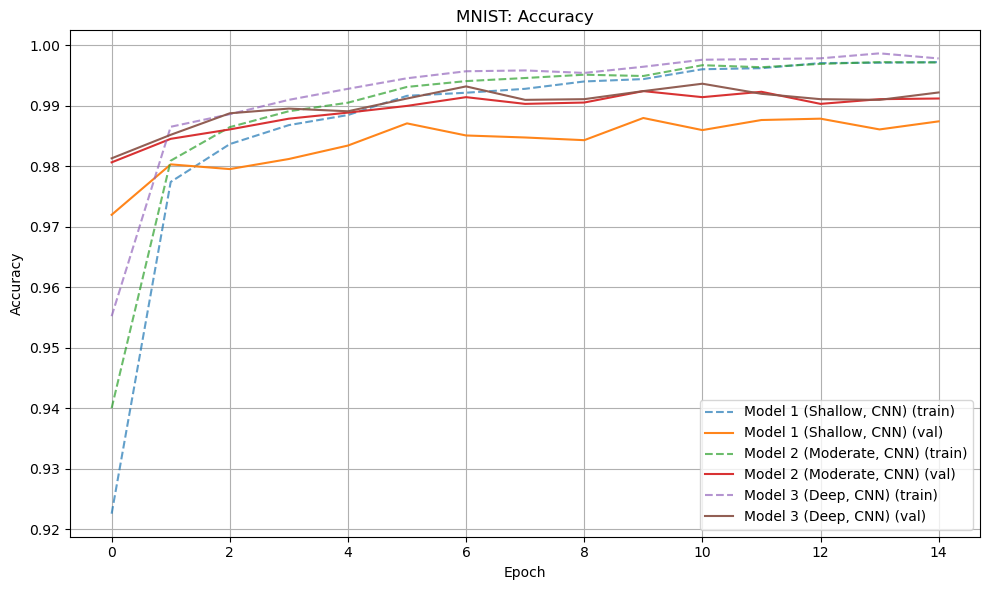

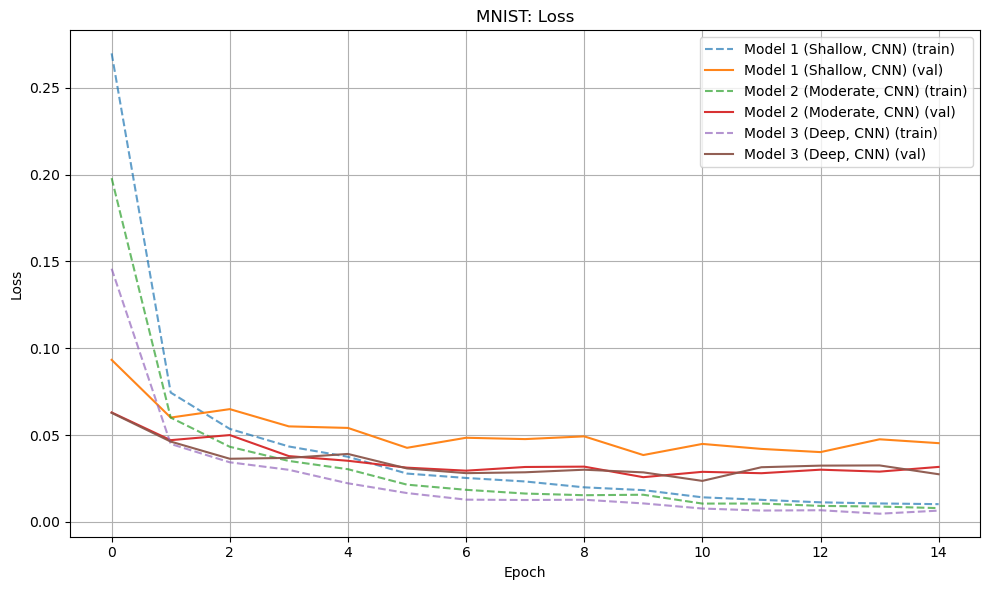


 Final Test Accuracy
Model 1 (Shallow, CNN): Test Acc = 98.82%
Model 2 (Moderate, CNN): Test Acc = 99.43%
Model 3 (Deep, CNN): Test Acc = 99.47%


In [1]:
import os, random
from dataclasses import dataclass
from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as T
EPOCHS   = 15          
BATCH    = 128
LR       = 1e-3
WEIGHT_DECAY = 1e-4    
VAL_PCT  = 0.15
OUTDIR   = "results_task_training_mnist"
SEED     = 2025
os.makedirs(OUTDIR, exist_ok=True)
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_mnist() -> Tuple[DataLoader, DataLoader, DataLoader]:
    # Normalize to MNIST mean/std
    transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])
    full_train = torchvision.datasets.MNIST("./data", train=True,  transform=transform, download=True)
    test_ds    = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)

    n_val = int(len(full_train) * VAL_PCT)
    train_ds, val_ds = random_split(full_train, [len(full_train)-n_val, n_val],
                                    generator=torch.Generator().manual_seed(SEED))
    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH*2, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH*2, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader


class MNIST_CNN_Shallow(nn.Module):
    
    def __init__(self, n_classes=10):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, padding=1)
        self.c2 = nn.Conv2d(16, 32, 3, padding=1)
        self.p  = nn.MaxPool2d(2,2)
        self.f  = nn.Linear(32*7*7, n_classes)
    def forward(self, x):
        x = self.p(F.relu(self.c1(x)))   # 16×14×14
        x = self.p(F.relu(self.c2(x)))   # 32×7×7
        x = x.view(x.size(0), -1)
        return self.f(x)

class MNIST_CNN_Moderate(nn.Module):
    
    def __init__(self, n_classes=10):
        super().__init__()
        self.c1 = nn.Conv2d(1, 32, 3, padding=1)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        self.c3 = nn.Conv2d(64, 64, 3, padding=1)
        self.p  = nn.MaxPool2d(2,2)
        self.d  = nn.Dropout(0.25)
        self.f  = nn.Linear(64*7*7, n_classes)
    def forward(self, x):
        x = self.p(F.relu(self.c1(x)))   # 32×14×14
        x = F.relu(self.c2(x))           # 64×14×14
        x = self.p(F.relu(self.c3(x)))   # 64×7×7
        x = x.view(x.size(0), -1)
        x = self.d(x)
        return self.f(x)

class MNIST_CNN_Deep(nn.Module):
    
    def __init__(self, n_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),                              # 32×14×14
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),                              # 64×7×7
        )
        self.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(64*7*7, n_classes))
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def build_models() -> Dict[str, nn.Module]:
    return {
        "Model 1 (Shallow, CNN)":  MNIST_CNN_Shallow(),
        "Model 2 (Moderate, CNN)": MNIST_CNN_Moderate(),
        "Model 3 (Deep, CNN)":     MNIST_CNN_Deep(),
    }


@dataclass
class TrainCfg:
    epochs: int = EPOCHS
    lr: float = LR
    weight_decay: float = WEIGHT_DECAY

def accuracy(logits, y): return (logits.argmax(1) == y).float().mean().item()

def train_one_epoch(model, loader, opt, loss_fn):
    model.train(); tl, ta, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb); loss = loss_fn(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        bs = xb.size(0); tl += loss.item()*bs; ta += accuracy(logits, yb)*bs; n += bs
    return tl/n, ta/n

@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval(); tl, ta, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb); loss = loss_fn(logits, yb)
        bs = xb.size(0); tl += loss.item()*bs; ta += accuracy(logits, yb)*bs; n += bs
    return tl/n, ta/n


def train_mnist_cnn():
    print("\n Training on MNIST (CNNs) ")
    train_loader, val_loader, test_loader = get_mnist()
    models = build_models()
    cfg = TrainCfg()

    history = {}
    best_states = {}

    for name, model in models.items():
        print(f"\n  Training {name} ...")
        model = model.to(device)
        opt = Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        sched = StepLR(opt, step_size=5, gamma=0.7)  # gentle LR decay
        loss_fn = nn.CrossEntropyLoss()

        tr_losses, va_losses, tr_accs, va_accs = [], [], [], []
        best_va, best_state = -1.0, None

        for epoch in range(1, cfg.epochs+1):
            tl, ta = train_one_epoch(model, train_loader, opt, loss_fn)
            vl, va = evaluate(model, val_loader, loss_fn)
            tr_losses.append(tl); va_losses.append(vl); tr_accs.append(ta); va_accs.append(va)

            if va > best_va:
                best_va = va
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

            print(f"   epoch {epoch:02d}/{cfg.epochs} | "
                  f"train_loss {tl:.4f} acc {ta*100:5.2f}% | "
                  f"val_loss {vl:.4f} acc {va*100:5.2f}%")

            sched.step()

        history[name] = {"train_loss": tr_losses, "val_loss": va_losses,
                         "train_acc": tr_accs,   "val_acc":  va_accs}
        best_states[name] = best_state

    
    plt.figure(figsize=(10,6))
    for name in models.keys():
        plt.plot(history[name]["train_acc"], linestyle="--", alpha=0.7, label=f"{name} (train)")
        plt.plot(history[name]["val_acc"],               alpha=0.95, label=f"{name} (val)")
    plt.title("MNIST: Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "mnist_accuracy.png"), dpi=150)
    plt.show(); plt.close()

    
    plt.figure(figsize=(10,6))
    for name in models.keys():
        plt.plot(history[name]["train_loss"], linestyle="--", alpha=0.7, label=f"{name} (train)")
        plt.plot(history[name]["val_loss"],               alpha=0.95, label=f"{name} (val)")
    plt.title("MNIST: Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "mnist_loss.png"), dpi=150)
    plt.show(); plt.close()

    
    print("\n Final Test Accuracy")
    for name, model in models.items():
        state = best_states[name]
        if state is not None:
            model.load_state_dict(state)
        model = model.to(device)
        test_loss, test_acc = evaluate(model, test_loader, nn.CrossEntropyLoss())
        print(f"{name}: Test Acc = {test_acc*100:.2f}%")

if __name__ == "__main__":
    train_mnist_cnn()
